#### In this notebook, we build logistic regression classifiers on breast cancer dataset to predict whether the cancer is malignant or benign on the patients. The dataset contains 569 samples and 30 features.
https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic) 

In [2]:
# Load Packages
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv("data.csv")

In [4]:

data.head()


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [538]:
data['diagnosis'] = data['diagnosis'].replace(['M'], -1)
data['diagnosis'] = data['diagnosis'].replace(['B'], 1)
X = data.iloc[:,2:32].to_numpy()
X = np.hstack((np.ones((X.shape[0], 1)), X))
y = data.iloc[:,1].to_numpy()
X.shape

(569, 31)

In [539]:
# partition using 80% training data and 20% testing data. It is a commonly used ratio in machine learning.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.20)


Use the standardization to transform both training and test features

In [540]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[ 0.         -0.06995243  0.07833912 -0.07360645 -0.0848529  -0.07847337
 -0.04188102 -0.04195393 -0.09543579  0.07307746 -0.00183849 -0.05403559
 -0.08152607 -0.06429298 -0.08347985  0.03788353  0.05383082  0.10298183
 -0.02612546 -0.03292575  0.06531189 -0.07967889  0.01904825 -0.08498616
 -0.09418661 -0.06887409 -0.03546623 -0.02954745 -0.09374066  0.04297809
  0.01075073]
test std = 
[0.         0.90953681 0.92941972 0.91438869 0.84198638 0.96015052
 1.04832403 1.02360736 0.99886349 1.13765541 1.02044253 0.88459952
 0.90749103 0.85707362 0.65548782 1.23024225 1.23566785 1.36513816
 1.12594446 1.24075689 1.1298291  0.90555829 0.87791173 0.89980251
 0.8337531  0.94528266 0.95771687 1.04314574 0.97605652 1.16764272
 0.93675878]


# Logistic Regression Model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

When $\lambda = 0$, the model is a regular logistic regression and when $\lambda > 0$, it essentially becomes a regularized logistic regression.

In [541]:
# To calculate the objective or loss function
# Inputs:
#     w: weight: d-by-1 matrix
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: regularization parameter: scalar
# Return:
#     objective function value, or loss (scalar)
def objective(w, x, y, lam):
    q=0
    n, d = x.shape
    for i in range(0,n):
        xi = x[i]
        xw = numpy.dot(x[i],w)
        
        exped = numpy.exp(y[i]*xw)
#        
        q = q+ numpy.log(1+(1/exped))  + (lam/2)*(numpy.linalg.norm(w,ord=2))
        
    return (1/n)*q


def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## Gradient descent


The gradient at $w$ for regularized logistic regression is  $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [542]:
# Calculating the gradient
# Inputs:
#     w: weight: d-by-1 matrix
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: regularization parameter: scalar
# Return:
#     g: gradient: d-by-1 matrix

def gradient(w, x, y, lam):
    g=0
    n, d = x.shape
    for i in range(n):
        numerator = np.dot(x[i],y[i])
        xw = numpy.dot(x[i],w)
        denominator = 1 + np.exp(y[i]*xw)
        g = g+ numerator/denominator + lam*w
    return -((1/n)*g) + lam*w

In [543]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value

def gradient_descent(x, y, lam, learning_rate, w, max_epoch=100):
    history = np.zeros((max_epoch, 1))
    for i in range(max_epoch):
        w = w-(learning_rate)*gradient(w,x,y,lam)
        history[i] = objective(w,x,y,lam)
    return w,history
    

Using gradient_descent function to obtain your optimal weights and a list of objective values over each epoch.

In [544]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
w = np.zeros(x_train.shape[1])
gd_weights, gd_hist = gradient_descent(x_train, y_train, 0, 5, w, max_epoch=100)
gd_weights, gd_hist

(array([ 0.        , -0.5149968 , -0.83379586, -0.52391599, -0.77984781,
        -0.23525737,  0.71549269, -1.4319519 , -1.54257806,  0.03988274,
         0.16597182, -2.00581007,  0.0841455 , -1.42598586, -1.54735735,
         0.27069204,  1.7065987 ,  0.10223962, -0.38897844,  0.28361182,
         1.46669504, -1.40256023, -1.50895586, -1.26363855, -1.52300711,
        -1.43443694,  0.2973711 , -1.41008306, -1.33225618, -0.94288638,
        -0.60133956]),
 array([[0.3805691 ],
        [0.22871822],
        [0.13889476],
        [0.11203867],
        [0.09841088],
        [0.0909264 ],
        [0.08674027],
        [0.08379168],
        [0.08139747],
        [0.07932267],
        [0.07746848],
        [0.07578439],
        [0.07424006],
        [0.07281508],
        [0.07149461],
        [0.07026727],
        [0.06912398],
        [0.06805722],
        [0.06706059],
        [0.06612851],
        [0.06525599],
        [0.06443856],
        [0.06367211],
        [0.06295285],
        [0.

In [545]:
# Train regularized logistic regression
# You get the optimal weights and a list of objective values by using gradient_descent function.
reg_gd_weights, reg_gd_hist = gradient_descent(x_train, y_train, 0.00003, 5, w, max_epoch=100)
reg_gd_weights, reg_gd_hist

(array([ 0.        , -0.5149968 , -0.83379586, -0.52391599, -0.77984781,
        -0.23525737,  0.71549269, -1.4319519 , -1.54257806,  0.03988274,
         0.16597182, -2.00581007,  0.0841455 , -1.42598586, -1.54735735,
         0.27069204,  1.7065987 ,  0.10223962, -0.38897844,  0.28361182,
         1.46669504, -1.40256023, -1.50895586, -1.26363855, -1.52300711,
        -1.43443694,  0.2973711 , -1.41008306, -1.33225618, -0.94288638,
        -0.60133956]),
 array([[0.38067494],
        [0.22882128],
        [0.13899632],
        [0.11213934],
        [0.09851084],
        [0.09102578],
        [0.08683913],
        [0.08389006],
        [0.0814954 ],
        [0.07942016],
        [0.07756556],
        [0.07588108],
        [0.07433638],
        [0.07291104],
        [0.07159023],
        [0.07036257],
        [0.06921897],
        [0.06815191],
        [0.06715499],
        [0.06622263],
        [0.06534986],
        [0.06453218],
        [0.06376548],
        [0.06304599],
        [0.

## 3.2. Stochastic gradient descent (SGD)

New objective function $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $. 

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.


In [546]:
# Calculates the objective Q_i and the gradient of Q_i
# Inputs:
#     w: weights: d-by-1 matrix
#     xi: data: 1-by-d matrix
#     yi: label: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    
    q=0
    xw = numpy.dot(xi,w)
    exped = numpy.exp(yi*xw)
    q = numpy.log(1+(1/exped))  + (lam/2)*(numpy.linalg.norm(w,ord=2))
    
    numerator = np.dot(xi,yi)
    xw = numpy.dot(xi,w)
    denominator = 1 + np.exp(yi*xw)
    g = -numerator/denominator + lam*w
    
    return g, q



In [547]:
# SGD for solving logistic regression
# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)

def sgd(x, y, lam, learning_rate, w, max_epoch=100):
    history = np.zeros((max_epoch, 1))
    n = len(y)
    for i in range(max_epoch):
        obj=0
        permutation = np.random.permutation(n)
        x_permuted = x[permutation, :]
        y_permuted = y[permutation]
        for j in range(n):
            gradient, objective = stochastic_objective_gradient(w,x[j],y[j],lam)
            w = w-(learning_rate)*gradient
            obj += objective
        history[i] = obj/n
    return w, history

Use sgd function to obtain your optimal weights and a list of objective values over each epoch.

In [548]:
# Train logistic regression
# Get the optimal weights and a list of objective values by using gradient_descent function.
w = np.zeros(x_train.shape[1])
sgd_weights, sgd_hist = sgd(x_train, y_train, 0, .1, w, max_epoch=100)
sgd_weights, sgd_hist

(array([ 0.        , -0.27411153, -0.43686041, -0.47677796, -0.16569767,
         0.54528483,  3.132883  , -3.80015796, -3.39453504,  0.67959626,
        -0.23208141, -4.33492707,  0.80988268, -1.60265061, -1.25150084,
         1.5473826 ,  2.55099844, -0.24171891, -3.05023845,  0.50034308,
         4.3346209 , -1.8874812 , -2.23862947, -1.69447158, -0.90876439,
        -1.84901709,  1.23993779, -2.78108393,  0.18031612, -1.43812382,
        -3.25172908]),
 array([[0.11224918],
        [0.07147058],
        [0.06519412],
        [0.06174701],
        [0.05938528],
        [0.05760632],
        [0.05618941],
        [0.05501966],
        [0.05403034],
        [0.05317903],
        [0.05243661],
        [0.05178173],
        [0.0511981 ],
        [0.05067306],
        [0.0501967 ],
        [0.04976125],
        [0.04936054],
        [0.04898962],
        [0.04864446],
        [0.04832176],
        [0.04801876],
        [0.04773315],
        [0.04746297],
        [0.04720655],
        [0.

In [549]:
# Train regularized logistic regression
# Get the optimal weights and a list of objective values by using gradient_descent function.
w = np.zeros(x_train.shape[1])
reg_sgd_weights, reg_sgd_hist = sgd(x_train, y_train, .000003, 0.1, w, max_epoch=100)
reg_sgd_weights, reg_sgd_hist

(array([ 0.        , -0.27412447, -0.43526683, -0.47564312, -0.16807045,
         0.54325275,  3.10963742, -3.78026358, -3.37456182,  0.6722511 ,
        -0.2309933 , -4.30831051,  0.80464357, -1.59613954, -1.2475683 ,
         1.53586623,  2.53839603, -0.23843564, -3.02782026,  0.4970353 ,
         4.30976162, -1.87917917, -2.22821865, -1.68760074, -0.90946164,
        -1.83917571,  1.23106634, -2.76814156,  0.17700921, -1.43173831,
        -3.22981003]),
 array([[0.11225399],
        [0.07147867],
        [0.06520364],
        [0.06175773],
        [0.05939705],
        [0.05761906],
        [0.05620306],
        [0.05503422],
        [0.05404579],
        [0.05319537],
        [0.05245382],
        [0.0517998 ],
        [0.05121699],
        [0.05069274],
        [0.05021714],
        [0.04978243],
        [0.04938243],
        [0.04901221],
        [0.04866773],
        [0.04834568],
        [0.04804333],
        [0.04775835],
        [0.0474888 ],
        [0.04723299],
        [0.

## 3.3 Mini-Batch Gradient Descent (MBGD)

 $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.


In [550]:
# Calculates the objective Q_I and the gradient of Q_I
# Inputs:
#     w: weights: d-by-1 vector
#     xi: data: b-by-d matrix
#     yi: label: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i

def mb_objective_gradient(w, xi, yi, lam):
    q=0
    b, d = xi.shape
    for i in range(0,b):
        xw = numpy.dot(xi[i],w)
        exped = numpy.exp(yi[i]*xw)
        q = q+ numpy.log(1+(1/exped))  + (lam/2)*(numpy.linalg.norm(w,ord=2))
        
    g=0
    b, d = xi.shape
    for j in range(b):
        numerator = np.dot(xi[j],yi[j])
        xw = numpy.dot(xi[j],w)
        denominator = 1 + np.exp(yi[j]*xw)
        g = g+ numerator/denominator + lam*w
        
    return (1/b)*q , -((1/b)*g) + lam*w  

In [551]:
# MBGD for solving logistic regression
# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)

def mbgd(x, y, lam, learning_rate, w, max_epoch=100):
    batch_size = 20
    n = len(y)
    history = np.zeros((max_epoch, 1))
    for i in range(max_epoch):
        obj_av = 0
        permutation = np.random.permutation(n)
        X_permuted = x[permutation, :]
        y_permuted = y[permutation]
        for j in range(0, n, batch_size):
            X_batch = X_permuted[j:j+batch_size, :]
            y_batch = y_permuted[j:j+batch_size]
            objective, gradient = mb_objective_gradient(w, X_batch, y_batch, lam)
            w = w - learning_rate * gradient
            obj_av+= objective
        history[i] = obj_av/(n/batch_size)
    return w, history   

Use mbgd function to obtain your optimal weights and a list of objective values over each epoch.

In [552]:
# Train logistic regression
# Get the optimal weights and a list of objective values by using gradient_descent function.
mbgd_weights, mbgd_hist = mbgd(x_train, y_train, 0, 1, w, max_epoch=100)
mbgd_weights, mbgd_hist

(array([ 0.        , -0.11093559, -0.76151811, -0.22589891, -0.2979592 ,
         0.1875923 ,  2.07996961, -2.61374712, -2.55334075,  0.52240538,
        -0.04782153, -3.03588857,  0.56445855, -1.76739458, -1.4711661 ,
         0.79778872,  2.28175589, -0.45605364, -1.8440263 ,  0.50982077,
         2.66360507, -1.53144752, -1.68769974, -1.46645826, -1.29536543,
        -1.46522845,  0.91256231, -2.01012659, -0.69456593, -1.24782882,
        -1.9229345 ]),
 array([[0.12658771],
        [0.07863877],
        [0.07068843],
        [0.06729113],
        [0.06435777],
        [0.06129123],
        [0.06484206],
        [0.05927105],
        [0.05827082],
        [0.05671722],
        [0.05546586],
        [0.05476485],
        [0.05875516],
        [0.05454943],
        [0.05339734],
        [0.05374985],
        [0.05220011],
        [0.05161939],
        [0.05153435],
        [0.05209797],
        [0.05048746],
        [0.05044148],
        [0.04959027],
        [0.04930155],
        [0.

In [553]:
# Train regularized logistic regression
# Get the optimal weights and a list of objective values by using gradient_descent function.
reg_mbgd_weights, reg_mbgd_hist = mbgd(x_train, y_train, 0.00003, 1, w, max_epoch=100)
reg_mbgd_weights, reg_mbgd_hist

(array([ 0.        , -0.13099726, -0.82580233, -0.23916322, -0.26319228,
         0.20161273,  2.12160649, -2.60509535, -2.50334256,  0.55249337,
        -0.05387975, -3.04843742,  0.50994746, -1.74807954, -1.48767971,
         0.81645197,  2.28607282, -0.46229304, -1.88264382,  0.51276427,
         2.68360073, -1.5438351 , -1.75919693, -1.45990347, -1.25705324,
        -1.49586891,  0.93584975, -2.04908739, -0.66723733, -1.27138114,
        -1.95777101]),
 array([[0.13711795],
        [0.08057707],
        [0.07214476],
        [0.06666123],
        [0.06386943],
        [0.06204053],
        [0.05939488],
        [0.06104274],
        [0.05746959],
        [0.05670917],
        [0.0555137 ],
        [0.05462491],
        [0.05399677],
        [0.05344655],
        [0.05226446],
        [0.0525189 ],
        [0.05190102],
        [0.05147985],
        [0.05321563],
        [0.05216857],
        [0.04981155],
        [0.04979779],
        [0.05528882],
        [0.0497534 ],
        [0.

# Comparing GD, SGD, MBGD

### Plot objective function values against epochs.

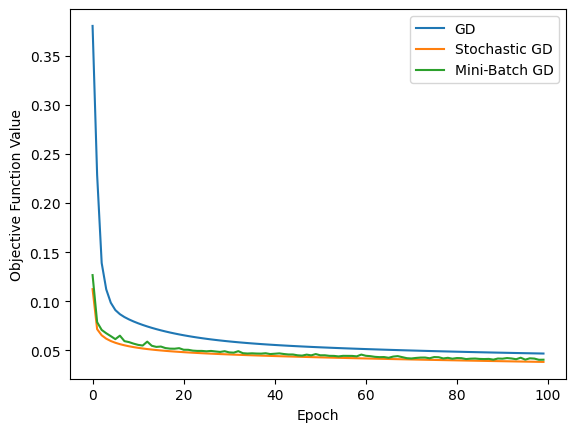

In [554]:
# Comparing GD, SGD and MBGD
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(gd_hist, label='GD')
plt.plot(sgd_hist, label='Stochastic GD')
plt.plot(mbgd_hist, label='Mini-Batch GD')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Objective Function Value')
plt.show()

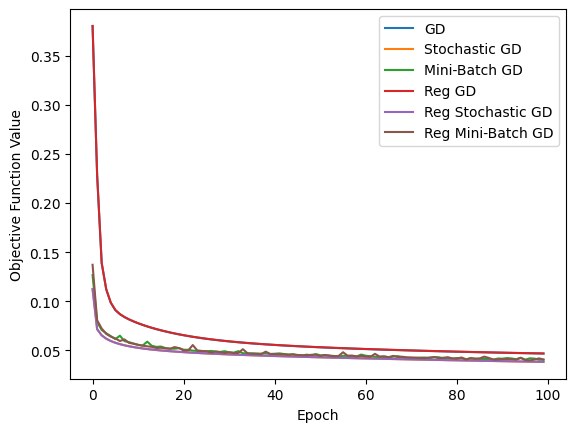

In [555]:
#Comparing all our models
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(gd_hist, label='GD')
plt.plot(sgd_hist, label='Stochastic GD')
plt.plot(mbgd_hist, label='Mini-Batch GD')
plt.plot(reg_gd_hist, label='Reg GD')
plt.plot(reg_sgd_hist, label='Reg Stochastic GD')
plt.plot(reg_mbgd_hist, label='Reg Mini-Batch GD')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Objective Function Value')
plt.show()


# Prediction
### Compare the training and testing accuracy for logistic regression and regularized logistic regression.

In [556]:
# Predict class label
# Inputs:
#     w: weights: d-by-1 matrix
#     X: data: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    z = X.dot(w)
    zsign = np.sign(z)
    zsign[zsign < 0] = -1
    zsign[zsign > 0] = 1
    return zsign.reshape(-1,1)
def evaluate(w, X, y):
    y_pred = predict(w, X)
    err = np.mean(y_pred != y)
    return err

In [557]:
# evaluate training error of logistic regression and regularized version
print("Training Error\n")
print("gd: "+ str(evaluate(gd_weights, x_train, y_train)))
print("regularized gd: "+ str(evaluate(reg_gd_weights, x_train, y_train)))
print("\nlogistic sgd: "+ str(evaluate(sgd_weights, x_train, y_train)))
print("regularized sgd: "+ str(evaluate(reg_sgd_weights, x_train, y_train)))
print("\nlogistic mbgd: "+ str(evaluate(mbgd_weights, x_train, y_train)))
print("regularized mbgd: "+ str(evaluate(reg_mbgd_weights, x_train, y_train)))


Training Error

gd: 0.47079821277623474
regularized gd: 0.47079821277623474

logistic sgd: 0.47079821277623474
regularized sgd: 0.47079821277623474

logistic mbgd: 0.47028136698466366
regularized mbgd: 0.47028136698466366


In [558]:
# evaluate testing error of logistic regression and regularized version
print("Testing Error\n")
print("gd: "+ str(evaluate(gd_weights, x_train, y_train)))
print("regularized gd: "+ str(evaluate(reg_gd_weights, x_test, y_test)))
print("\nlogistic sgd: "+ str(evaluate(sgd_weights, x_test, y_test)))
print("regularized sgd: "+ str(evaluate(reg_sgd_weights, x_test, y_test)))
print("\nlogistic mbgd: "+ str(evaluate(mbgd_weights, x_test, y_test)))
print("regularized mbgd: "+ str(evaluate(reg_mbgd_weights, x_test, y_test)))

Testing Error

gd: 0.47079821277623474
regularized gd: 0.4327485380116959

logistic sgd: 0.43859649122807015
regularized sgd: 0.43859649122807015

logistic mbgd: 0.43567251461988304
regularized mbgd: 0.43567251461988304
